In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pathlib, os, glob
import tempfile
import numpy as np
import pyarrow.dataset as ds
from dask import delayed
from fastparquet import ParquetFile
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
geodata = pd.read_csv('../COVID19_USA/data/geodata_territories_2019_statelevel.csv',
                     converters={'geoid': lambda x: str(x)})

Notes from configs: 
- 250 differences between the two configs
- only the value of vaccine intervention differs --> order of SNPI should be the same

First assessement:
- hpar: all the same from the same slot
- hnpi: all the same for the same slot
- spar: all the same for the same slot
- seed: differ in date and amount for the same slot
- snpi: 
    - differ in geoid, start/end_dates. This is weird cause it's in the same order in the config. Anyway...
    - differ in reduction, this is expected... 

so we compare vector of NPIs, but we sort them by npi_name and geoid so it works.

In [3]:
run_ids = ['SMH_R9_ChildVax_noVar', 'SMH_R9_noChildVax_noVar']
def get_folder(run_id, ftype='hnpi'):
    return f's3pull/compareSLOTS/{run_id}/{ftype}/USA/inference/med/{run_id}/global/final/'

In [4]:
max_f = -1
run_files = {}
all_files = []
for run_id in run_ids:
    file_list = glob.glob(get_folder(run_id, 'snpi') + "*.parquet") # "*.csv")# 
    file_list.sort()
    file_list = file_list[:max_f]
    print(run_id, len(file_list))
    run_files[run_id] = file_list 
    all_files += file_list 
print(len(all_files))

SMH_R9_ChildVax_noVar 283
SMH_R9_noChildVax_noVar 281
564


In [5]:
dfs = []
for run_id in run_ids:
    dfs.append(pq.read_table(run_files[run_id][21]).to_pandas())
    #dfs.append(pd.read_csv(run_files[run_id][21]))
    print(run_files[run_id][21])
(dfs[0] == dfs[1]).all()

s3pull/compareSLOTS/SMH_R9_ChildVax_noVar/snpi/USA/inference/med/SMH_R9_ChildVax_noVar/global/final/000000023.SMH_R9_ChildVax_noVar.snpi.parquet
s3pull/compareSLOTS/SMH_R9_noChildVax_noVar/snpi/USA/inference/med/SMH_R9_noChildVax_noVar/global/final/000000023.SMH_R9_noChildVax_noVar.snpi.parquet


geoid         False
npi_name       True
start_date    False
end_date      False
parameter      True
reduction     False
dtype: bool

In [8]:
(dfs[0].sort_values(['geoid','npi_name'], ignore_index=True) == dfs[1].sort_values(['geoid','npi_name'], ignore_index=True)).all()

geoid          True
npi_name       True
start_date     True
end_date       True
parameter      True
reduction     False
dtype: bool

In [9]:
dfs[1][~(dfs[0].geoid == dfs[1].geoid)]

,geoid,npi_name,start_date,end_date,parameter,reduction
55,45000,lockdown,2020-04-07,2020-04-20,r0,0.514755
56,33000,lockdown,2020-03-27,2020-05-10,r0,0.485217
57,78000,lockdown,"2020-03-25,2020-08-17","2020-05-03,2020-09-18",r0,0.422143
58,24000,lockdown,2020-03-30,2020-05-14,r0,0.272901
59,23000,lockdown,2020-04-02,2020-04-30,r0,0.716033
...,...,...,...,...,...,...
1000,04000,Seas_dec,"2020-12-01,2021-12-01","2020-12-31,2021-12-31",r0,-0.604091
1001,25000,Seas_dec,"2020-12-01,2021-12-01","2020-12-31,2021-12-31",r0,-0.019412
1002,66000,Seas_dec,"2020-12-01,2021-12-01","2020-12-31,2021-12-31",r0,-0.262269
1003,46000,Seas_dec,"2020-12-01,2021-12-01","2020-12-31,2021-12-31",r0,0.251448


In [7]:
fn = run_files[run_id][0]
n_feature = len(pq.read_table(fn).to_pandas().sort_values(['geoid','npi_name'], ignore_index=True)['reduction'].to_numpy())
fn.split('/')[-1].split('.')

['000000001', 'SMH_R9_noChildVax_noVar', 'snpi', 'parquet']

In [34]:
n_feature

3423

In [27]:
features_matrices = {}
for run_id in run_ids:
    arr = np.empty((300,n_feature))
    arr[:] = np.NaN#1000
    features_matrices[run_id] = arr
    
for fn in tqdm(all_files):
    features = pq.read_table(fn).to_pandas().sort_values(['geoid','npi_name'], ignore_index=True)['reduction'].to_numpy()
    slot = int(fn.split('/')[-1].split('.')[0]) -1
    run_id = fn.split('/')[-1].split('.')[1]
    features_matrices[run_id][slot] = features

100%|██████████| 564/564 [00:04<00:00, 128.65it/s]


In [29]:
import scipy.spatial
diff = scipy.spatial.distance_matrix(features_matrices[run_ids[0]], features_matrices[run_ids[1]], p=2)
diff2 = scipy.spatial.distance_matrix(features_matrices[run_ids[1]], features_matrices[run_ids[0]], p=2)

In [77]:
run_ids[0]

'SMH_R9_ChildVax_noVar'

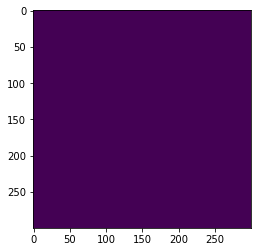

In [10]:
plt.imshow(diff.T == diff2)

In [23]:
#from sklearn.metrics.pairwise import euclidean_distances

#diff1 = euclidean_distances(features_matrices[run_ids[0]], features_matrices[run_ids[1]])
#diff2 = euclidean_distances(features_matrices[run_ids[1]], features_matrices[run_ids[0]])
#diff = euclidean_distances(features_matrices[run_ids[1]], features_matrices[run_ids[0]])

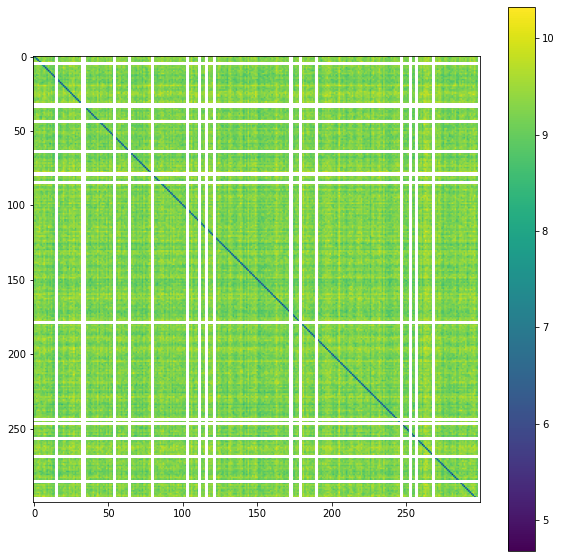

In [30]:
fig, axes = plt.subplots(1,1, figsize=(10,10), facecolor='white')
pos = axes.imshow(diff)
fig.colorbar(pos, ax=axes)

In [18]:
df = pq.read_table(fn.replace('snpi','hosp')).to_pandas()

In [26]:
df[['incidC', 'time']].groupby('time').sum().loc['2021-11-1':, :]

,incidC
time,
2021-11-01,219613.531138
2021-11-02,220827.067492
2021-11-03,221836.992039
2021-11-04,222632.634551
2021-11-05,223207.427708
...,...
2022-03-08,13329.797872
2022-03-09,12804.752810
2022-03-10,12022.113370


In [13]:
cum_case = {}
for run_id in run_ids:
    arr = np.empty((300,1))
    cum_case[run_id] = arr

import datetime
for fn in tqdm(all_files):
    df = pq.read_table(fn.replace('snpi','hosp')).to_pandas()
    slot = int(fn.split('/')[-1].split('.')[0]) -1
    run_id = fn.split('/')[-1].split('.')[1]

    df = df[['incidC', 'time']].groupby('time').sum()
    n_cum_case = df.loc['2021-11-1':, :].sum()
    cum_case[run_id][slot] = n_cum_case
    
cum_case['SMH_R9_noChildVax_noVar'] = cum_case['SMH_R9_noChildVax_noVar'].flatten()
cum_case['SMH_R9_ChildVax_noVar'] = cum_case['SMH_R9_ChildVax_noVar'].flatten()

100%|██████████| 564/564 [00:14<00:00, 39.21it/s]


In [14]:
distance_from_noChildVax = pd.DataFrame(columns=[f'slot_in_noChildVax', f'closest_slot_in_other', 'distance', 'diff_cum_case_from_Nov1'],
                                    index=np.arange(1,301))
distance_from_ChildVax = pd.DataFrame(columns=[f'slot_in_ChildVax', f'closest_slot_in_other', 'distance','diff_cum_case_from_Nov1'],
                                    index=np.arange(1,301))

for slt in range(300):
    distance_from_noChildVax.loc[slt+1] = [slt+1, 
                                           np.argmin(diff[:,slt])+1, 
                                           diff[np.argmin(diff[slt,:]),slt], 
                                           cum_case['SMH_R9_noChildVax_noVar'][slt] - cum_case['SMH_R9_ChildVax_noVar'][np.argmin(diff[:,slt])]]
    distance_from_ChildVax.loc[slt+1] = [slt+1, 
                                         np.argmin(diff[slt,:])+1, 
                                         diff[slt, np.argmin(diff[slt,:])],
                                         cum_case['SMH_R9_ChildVax_noVar'][slt] - cum_case['SMH_R9_noChildVax_noVar'][np.argmin(diff[slt,:])]]

distance_from_noChildVax.loc[distance_from_noChildVax['distance'] < 1e-6, 'closest_slot_in_other'] = pd.NA
distance_from_noChildVax.loc[distance_from_noChildVax['distance'] < 1e-6, 'diff_cum_case_from_Nov1'] = pd.NA
distance_from_noChildVax.loc[distance_from_noChildVax['distance'] < 1e-6, 'distance'] = pd.NA

distance_from_noChildVax.loc[distance_from_noChildVax['distance'] > 1e2, 'closest_slot_in_other'] = pd.NA
distance_from_noChildVax.loc[distance_from_noChildVax['distance'] > 1e2, 'diff_cum_case_from_Nov1'] = pd.NA
distance_from_noChildVax.loc[distance_from_noChildVax['distance'] > 1e2, 'distance'] = pd.NA

distance_from_ChildVax.loc[distance_from_ChildVax['distance'] < 1e-6, 'closest_slot_in_other'] = pd.NA
distance_from_ChildVax.loc[distance_from_ChildVax['distance'] < 1e-6, 'diff_cum_case_from_Nov1'] = pd.NA
distance_from_ChildVax.loc[distance_from_ChildVax['distance'] < 1e-6, 'distance'] = pd.NA

distance_from_ChildVax.loc[distance_from_ChildVax['distance'] > 1e2, 'closest_slot_in_other'] = pd.NA
distance_from_ChildVax.loc[distance_from_ChildVax['distance'] > 1e2, 'diff_cum_case_from_Nov1'] = pd.NA
distance_from_ChildVax.loc[distance_from_ChildVax['distance'] > 1e2, 'distance'] = pd.NA


In [15]:
distance_from_ChildVax['diff_cum_case_from_Nov1'].mean()

-43978.95698391811

In [16]:
distance_from_noChildVax['diff_cum_case_from_Nov1'].mean()

103480.40375122866

In [17]:
distance_from_ChildVax.to_csv('distance_from_ChildVax.csv', index=False)
distance_from_noChildVax.to_csv('distance_from_noChildVax.csv', index=False)

In [35]:
diff[2,110]

9.316658895488072

In [36]:
diff[110,2]

9.24934934069685